In [1]:
import numpy as np
from matplotlib import pyplot as plt
import re
import os
import random
import pandas as pd
import tensorflow as tf
import keras
import glob
import cv2
import numpy as np
from random import shuffle
from tqdm import tqdm
from tensorflow.python.framework import graph_util
from keras.layers import *
from keras.optimizers import *
import sys
import pandas as pd
import pickle
import time
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam
from skimage.io import imshow
from keras.layers.normalization import BatchNormalization
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from sklearn.utils import shuffle
import numpy.random as rng
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
from functools import partial, update_wrapper
import pydot
#install pip pydot_ng
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Lambda
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import AveragePooling2D
from keras.layers import BatchNormalization
from keras.layers.merge import add, concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
import pydot
#install pip pydot_ng
import pydot_ng as pydot
print (pydot.find_graphviz())
np.random.seed(42)
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

Using TensorFlow backend.


{'dot': 'C:\\Program Files\\Graphviz 2.44.1\\bin\\dot.exe', 'twopi': '', 'neato': '', 'circo': '', 'fdp': '', 'sfdp': ''}


In [2]:
#print("tf.version is", tf.version)
#print("tf.keras.version is:", tf.keras.version)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

#tfback._get_available_gpus = _get_available_gpus
#tfback._get_available_gpus()
#tf.config.list_logical_devices()

In [3]:
# batch operation usng tensor slice
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = K.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = K.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = K.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = K.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H

In [4]:
def Wavelet(batch_image):
    # make channel first image
    batch_image = K.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:,0]
    g = batch_image[:,1]
    b = batch_image[:,2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = K.stack(wavelet_data, axis=1)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)


    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2, 
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = K.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = K.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = K.stack(wavelet_data_l4, axis=1)

    # print('shape before')
    # print(transform_batch.shape)
    # print(transform_batch_l2.shape)
    # print(transform_batch_l3.shape)
    # print(transform_batch_l4.shape)

    decom_level_1 = K.permute_dimensions(transform_batch, [0, 2, 3, 1])
    decom_level_2 = K.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
    decom_level_3 = K.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
    decom_level_4 = K.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])
    
    # print('shape after')
    # print(decom_level_1.shape)
    # print(decom_level_2.shape)
    # print(decom_level_3.shape)
    # print(decom_level_4.shape)
    return [decom_level_1, decom_level_2, decom_level_3, decom_level_4]


def Wavelet_out_shape(input_shapes):
    # print('in to shape')
    return [tuple([None, 112, 112, 12]), tuple([None, 56, 56, 12]), 
            tuple([None, 28, 28, 12]), tuple([None, 14, 14, 12])]

In [5]:
img_batch = K.zeros(shape=(8, 224, 224, 3), dtype='float32')
Wavelet(img_batch)


[<tf.Tensor 'transpose_73:0' shape=(8, 112, 112, 12) dtype=float32>,
 <tf.Tensor 'transpose_74:0' shape=(8, 56, 56, 12) dtype=float32>,
 <tf.Tensor 'transpose_75:0' shape=(8, 28, 28, 12) dtype=float32>,
 <tf.Tensor 'transpose_76:0' shape=(8, 14, 14, 12) dtype=float32>]

In [6]:
def get_wavelet_cnn_model():

    input_shape = 224, 224, 3

    input_ = Input(input_shape, name='the_input')
    # wavelet = Lambda(Wavelet, name='wavelet')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)
    # print(input_l1)
    # print(input_l2)
    # print(input_l3)
    # print(input_l4)
    # level one decomposition starts
    conv_1 = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_1')(input_l1)
    norm_1 = BatchNormalization(name='norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(norm_1)

    conv_1_2 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2')(relu_1)
    norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
    relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)

    # level two decomposition starts
    conv_a = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_a')(input_l2)
    norm_a = BatchNormalization(name='norm_a')(conv_a)
    relu_a = Activation('relu', name='relu_a')(norm_a)

    # concate level one and level two decomposition
    concate_level_2 = concatenate([relu_1_2, relu_a])
    conv_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_2')(concate_level_2)
    norm_2 = BatchNormalization(name='norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(norm_2)

    conv_2_2 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_2_2')(relu_2)
    norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
    relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)

    # level three decomposition starts 
    conv_b = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_b')(input_l3)
    norm_b = BatchNormalization(name='norm_b')(conv_b)
    relu_b = Activation('relu', name='relu_b')(norm_b)

    conv_b_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_b_2')(relu_b)
    norm_b_2 = BatchNormalization(name='norm_b_2')(conv_b_2)
    relu_b_2 = Activation('relu', name='relu_b_2')(norm_b_2)

    # concate level two and level three decomposition 
    concate_level_3 = concatenate([relu_2_2, relu_b_2])
    conv_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_3')(concate_level_3)
    norm_3 = BatchNormalization(name='nomr_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(norm_3)

    conv_3_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_3_2')(relu_3)
    norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
    relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)

    # level four decomposition start
    conv_c = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_c')(input_l4)
    norm_c = BatchNormalization(name='norm_c')(conv_c)
    relu_c = Activation('relu', name='relu_c')(norm_c)

    conv_c_2 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_2')(relu_c)
    norm_c_2 = BatchNormalization(name='norm_c_2')(conv_c_2)
    relu_c_2 = Activation('relu', name='relu_c_2')(norm_c_2)

    conv_c_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_3')(relu_c_2)
    norm_c_3 = BatchNormalization(name='norm_c_3')(conv_c_3)
    relu_c_3 = Activation('relu', name='relu_c_3')(norm_c_3)

    # concate level level three and level four decomposition
    concate_level_4 = concatenate([relu_3_2, relu_c_3])
    conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_4')(concate_level_4)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)

    conv_4_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)

    conv_5_1 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)

    pool_5_1 = AveragePooling2D(pool_size=(7, 7), strides=1, padding='same', name='avg_pool_5_1')(relu_5_1)
    flat_5_1 = Flatten(name='flat_5_1')(pool_5_1) 

    fc_5 = Dense(2048, name='fc_5')(flat_5_1)
    norm_5 = BatchNormalization(name='norm_5')(fc_5)
    relu_5 = Activation('relu', name='relu_5')(norm_5)
    drop_5 = Dropout(0.5, name='drop_5')(relu_5)

    fc_6 = Dense(2048, name='fc_6')(drop_5)
    norm_6 = BatchNormalization(name='norm_6')(fc_6)
    relu_6 = Activation('relu', name='relu_6')(norm_6)
    drop_6 = Dropout(0.5, name='drop_6')(relu_6)

    output = Dense(2, activation='softmax', name='fc_7')(drop_6)

    model = Model(inputs=input_, outputs=output)
    model.summary()
    plot_model(model, to_file='neurowavel_classification.png')
    #plot_model(model, show_shapes=True, show_layer_names=True)

    return model

In [7]:
model = get_wavelet_cnn_model()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
wavelet (Lambda)                [(None, 112, 112, 12 0           the_input[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 112, 112, 64) 6976        wavelet[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 112, 112, 64) 256         conv_1[0][0]                     
___________________________________________________________________________________________

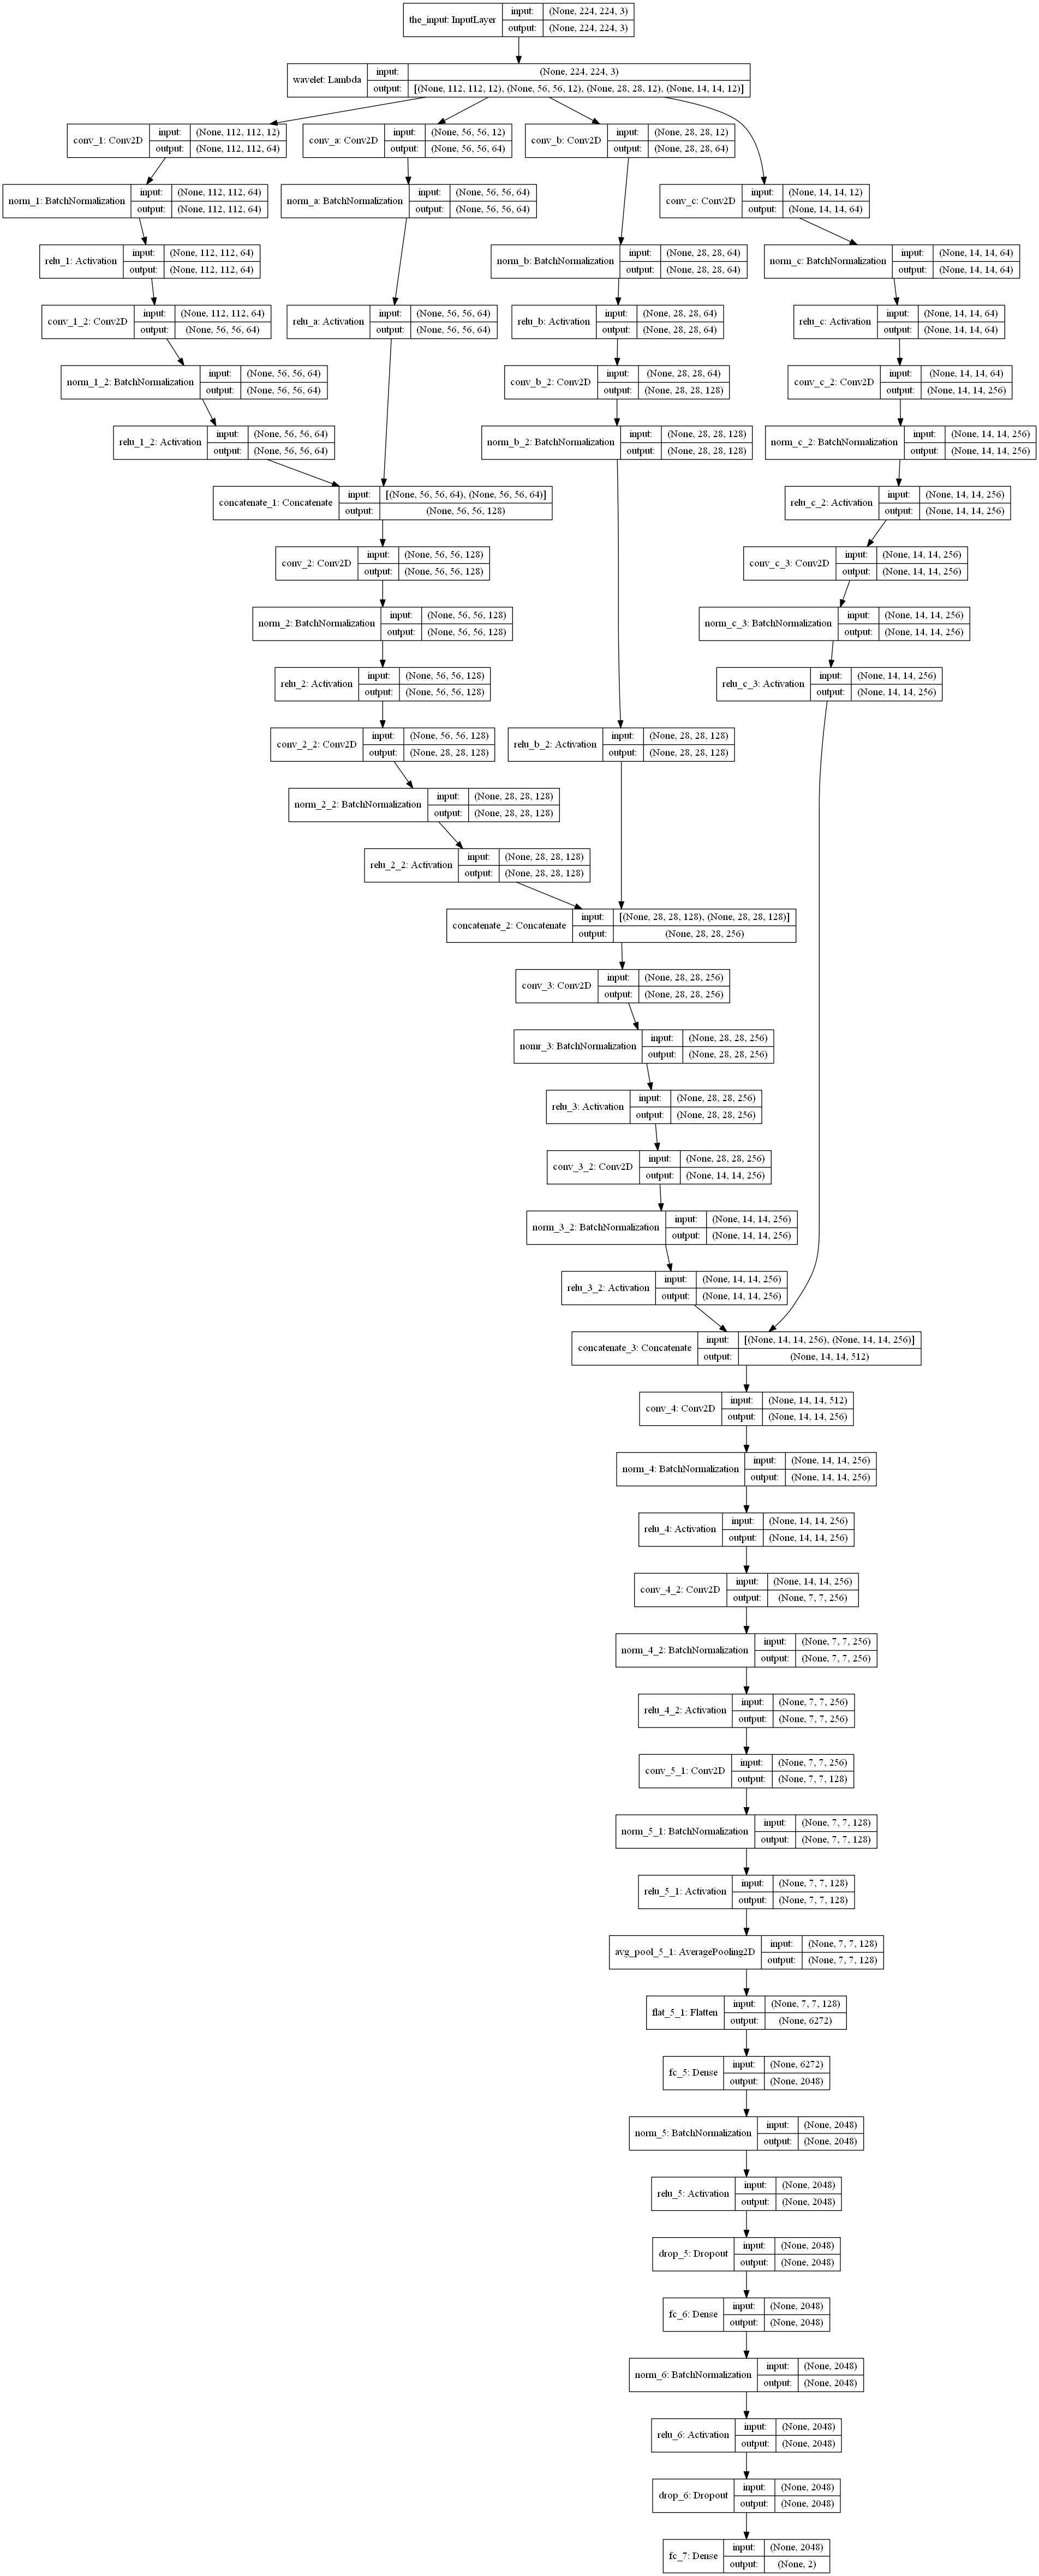

In [8]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [9]:
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
import os
data_set_path = 'D:/HAPPY WAVELET/Paper 1 Version 2 Classification with Training _Validation Directory/2 Classes/dataset'
os.listdir(data_set_path)

#D:\NEURAL-WAVELET CODES\Task 1\dataset\training_data
#D:\NEURAL-WAVELET CODES\Task 1\dataset\validation_data

['Training', 'Validation']

In [11]:
# prepare data augmentation configuration
#Data Division
nb_train_samples = 1120
nb_validation_samples =140
batch_size=32

train_data_gen = ImageDataGenerator(
    #rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
val_data_gen = ImageDataGenerator(
    #rescale=1./255
)

train_img_dir = 'D:/HAPPY WAVELET/Paper 1 Version 2 Classification with Training _Validation Directory/2 Classes/dataset/Training'
val_img_dir   = 'D:/HAPPY WAVELET/Paper 1 Version 2 Classification with Training _Validation Directory/2 Classes/dataset/Validation'

# def train & test generators
train_generator = train_data_gen.flow_from_directory(
    train_img_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')
val_generator = val_data_gen.flow_from_directory(
    val_img_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 1120 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


In [12]:
METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="AUC"),
        tf.keras.metrics.TruePositives(name="true_positives"),
        tf.keras.metrics.TrueNegatives(name="true_negatives"),
        tf.keras.metrics.FalsePositives(name="false_positives"),
        tf.keras.metrics.FalseNegatives(name="false_negatives"),
        keras.metrics.SensitivityAtSpecificity(0.5, name = "sensitivity"),
        keras.metrics.SpecificityAtSensitivity(0.5, name = "specificity")]
    
model.compile(optimizer=keras.optimizers.Adam(0.0004), loss="binary_crossentropy", metrics=METRICS)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:

history = model.fit_generator(
    train_generator,
    steps_per_epoch=1120//32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=140//32,
    verbose=True
)
model.save('neurowavel_class_2.h5')


Epoch 1/20
35/35 [==============================] - 13s 369ms/step - loss: 0.3922 - binary_accuracy: 0.8460 - precision: 0.8460 - recall: 0.8460 - AUC: 0.9178 - true_positives: 505.2286 - true_negatives: 505.2286 - false_positives: 70.7714 - false_negatives: 70.7714 - sensitivity: 0.9821 - specificity: 0.9821 - val_loss: 1.4203 - val_binary_accuracy: 0.8665 - val_precision: 0.8665 - val_recall: 0.8665 - val_AUC: 0.9333 - val_true_positives: 1039.5000 - val_true_negatives: 1039.5000 - val_false_positives: 160.5000 - val_false_negatives: 160.5000 - val_sensitivity: 0.5391 - val_specificity: 0.5312
Epoch 2/20
35/35 [==============================] - 11s 315ms/step - loss: 0.1148 - binary_accuracy: 0.8845 - precision: 0.8845 - recall: 0.8845 - AUC: 0.9478 - true_positives: 1617.6285 - true_negatives: 1617.6285 - false_positives: 206.3714 - false_negatives: 206.3714 - sensitivity: 0.9955 - specificity: 0.9955 - val_loss: 3.1022 - val_binary_accuracy: 0.8992 - val_precision: 0.8992 - val_re

35/35 [==============================] - 12s 333ms/step - loss: 0.0136 - binary_accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - AUC: 0.9902 - true_positives: 16039.5996 - true_negatives: 16039.5996 - false_positives: 560.4000 - false_negatives: 560.4000 - sensitivity: 1.0000 - specificity: 1.0000 - val_loss: 0.0100 - val_binary_accuracy: 0.9671 - val_precision: 0.9671 - val_recall: 0.9671 - val_AUC: 0.9906 - val_true_positives: 16648.0000 - val_true_negatives: 16648.0000 - val_false_positives: 566.0000 - val_false_negatives: 566.0000 - val_sensitivity: 1.0000 - val_specificity: 1.0000
Epoch 15/20
35/35 [==============================] - 12s 333ms/step - loss: 0.0297 - binary_accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - AUC: 0.9909 - true_positives: 17258.4277 - true_negatives: 17258.4277 - false_positives: 569.5714 - false_negatives: 569.5714 - sensitivity: 0.9982 - specificity: 0.9982 - val_loss: 2.9169e-05 - val_binary_accuracy: 0.9688 - val_precision: 0.9688 - val

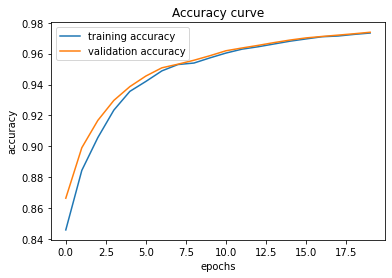

In [14]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
epochs = range(len(acc))

plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Accuracy curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

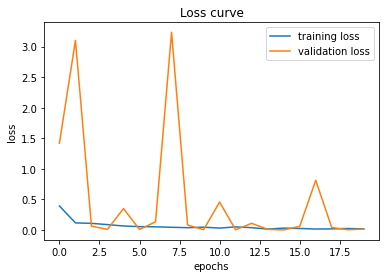

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

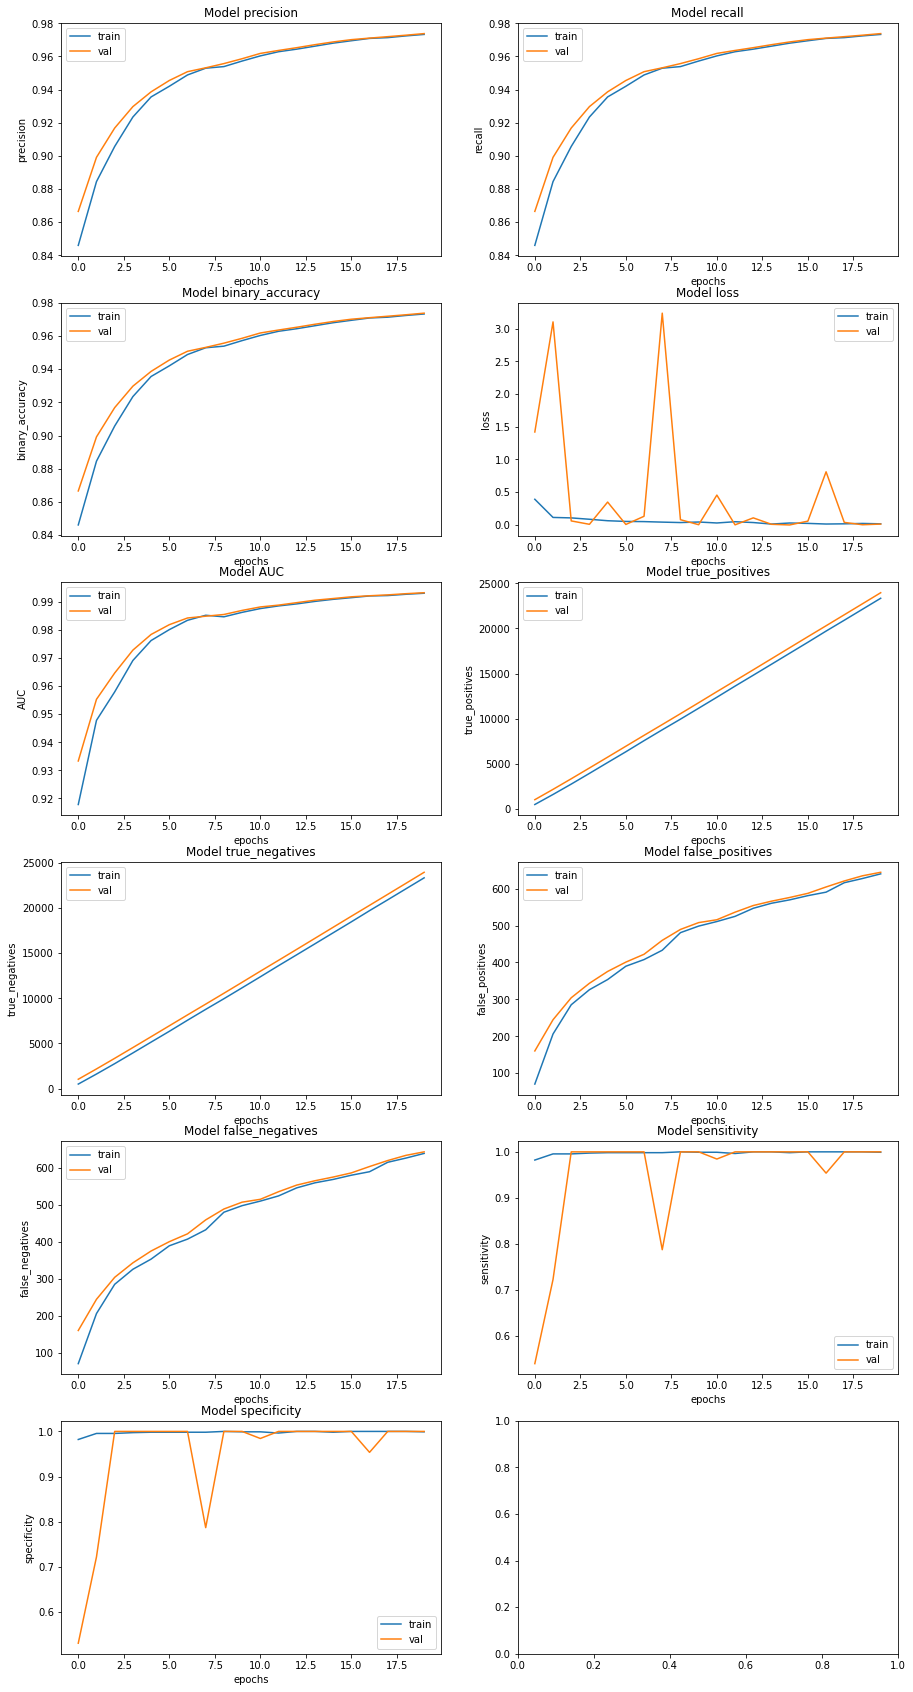

In [16]:
fig, ax = plt.subplots(6, 2, figsize=(15, 30))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss", "AUC", "true_positives", "true_negatives",
                        "false_positives", "false_negatives", "sensitivity", "specificity"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [17]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
pre = history.history['precision']
val_pre = history.history['val_precision']
rcall = history.history['recall']
val_rcall = history.history['val_recall']
aruc = history.history['AUC']
val_aruc = history.history['val_AUC']
loss = history.history['loss']
val_loss = history.history['val_loss']
true_pos = history.history['true_positives']
true_neg = history.history['true_negatives']
false_pos = history.history['false_positives']
false_neg = history.history['false_negatives']
val_true_pos = history.history['val_true_positives']
val_true_neg = history.history['val_true_negatives']
val_false_pos = history.history['val_false_positives']
val_false_neg = history.history['val_false_negatives']
sensitivity = history.history['sensitivity']
specificity = history.history['specificity']
val_sensitivity = history.history['val_sensitivity']
val_specificity = history.history['val_specificity']

epochs = range(1, len(acc) + 1)

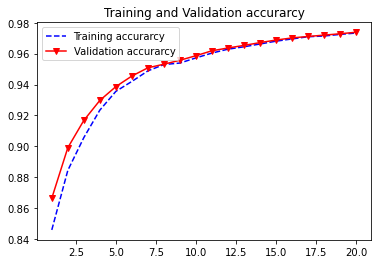

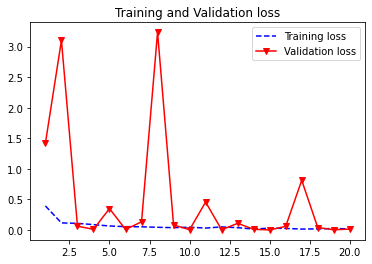

In [18]:

#Train and validation accuracy
plt.plot(epochs, acc, 'b--', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r-v', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'r-v', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


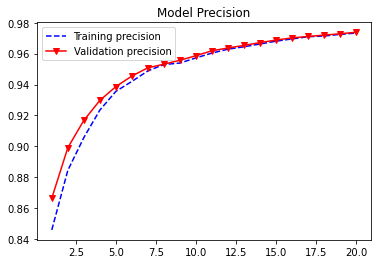

In [19]:
#Train and validation accuracy on Model Precision
plt.plot(epochs, pre, 'b--', label='Training precision')
plt.plot(epochs, val_pre, 'r-v', label='Validation precision')
plt.title('Model Precision')
plt.legend()



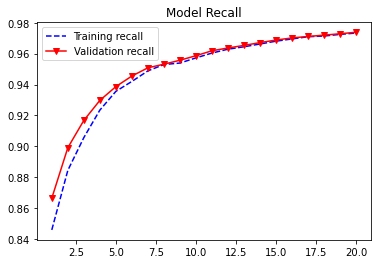

In [20]:
#Train and validation accuracy on Model Recall
plt.plot(epochs, rcall, 'b--', label='Training recall')
plt.plot(epochs, val_rcall, 'r-v', label='Validation recall')
plt.title('Model Recall')
plt.legend()


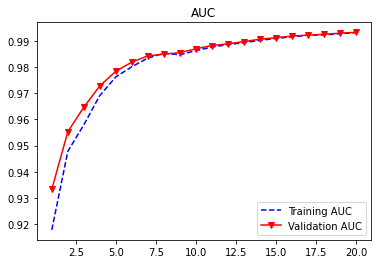

In [21]:
#Train and validation accuracy on Model AUC
plt.plot(epochs, aruc, 'b--', label='Training AUC')
plt.plot(epochs, val_aruc, 'r-v', label='Validation AUC')
plt.title('AUC')
plt.legend()

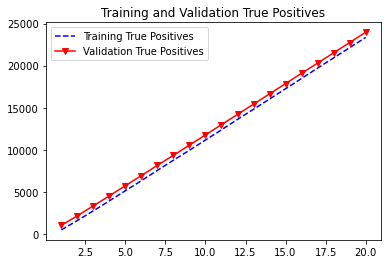

In [22]:
#Train and validation accuracy on True positives
plt.plot(epochs, true_pos, 'b--', label='Training True Positives')
plt.plot(epochs, val_true_pos, 'r-v', label='Validation True Positives')
plt.title('Training and Validation True Positives')
plt.legend()
plt.show()



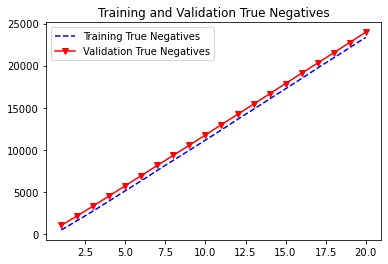

In [23]:
##Train and validation accuracy on True Negatives 
plt.plot(epochs, true_neg, 'b--', label='Training True Negatives')
plt.plot(epochs, val_true_neg, 'r-v', label='Validation True Negatives')
plt.title('Training and Validation True Negatives')
plt.legend()
plt.show()


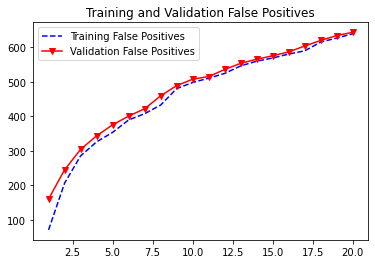

In [24]:
##Train and validation accuracy on False Positives
plt.plot(epochs, false_pos, 'b--', label='Training False Positives')
plt.plot(epochs, val_false_pos, 'r-v', label='Validation False Positives')
plt.title('Training and Validation False Positives')
plt.legend()
plt.show()


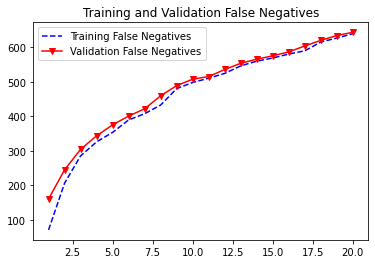

In [25]:
##Train and validation accuracy on False Negatives
plt.plot(epochs, false_neg, 'b--', label='Training False Negatives')
plt.plot(epochs, val_false_neg, 'r-v', label='Validation False Negatives')
plt.title('Training and Validation False Negatives')
plt.legend()
plt.show()

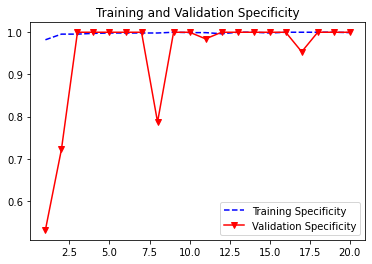

In [26]:
##Train and validation accuracy on specificity
plt.plot(epochs, specificity, 'b--', label='Training Specificity')
plt.plot(epochs, val_specificity, 'r-v', label='Validation Specificity')
plt.title('Training and Validation Specificity')
plt.legend()
plt.show()

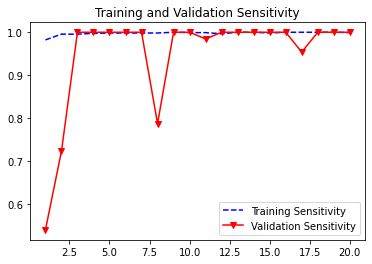

In [27]:
##Train and validation accuracy on Sensitivity
plt.plot(epochs, sensitivity, 'b--', label='Training Sensitivity')
plt.plot(epochs, val_sensitivity, 'r-v', label='Validation Sensitivity')
plt.title('Training and Validation Sensitivity')
plt.legend()
plt.show()

In [28]:
metrics = model.evaluate( train_generator) 
print( 'Loss of {} and Accuracy is {} %'.format( metrics[0] , metrics[1] * 100 ) )

35/35 [==============================] - 13s 358ms/step
Loss of 0.023087896406650543 and Accuracy is 97.36618995666504 %


In [30]:
metrics = model.evaluate(val_generator) 
print( 'Loss of {} and Accuracy is {} %'.format( metrics[0] , metrics[1] * 100 ) )

5/5 [==============================] - 0s 54ms/step
Loss of 0.013194232247769833 and Accuracy is 97.36267924308777 %


In [35]:
Y_pred = model.predict_generator(val_generator, nb_validation_samples//batch_size +1)
y_pred = np.argmax(Y_pred, axis=1)

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
%matplotlib inline
import itertools

#confusion Matrix and Classification Report
Y_pred = model.predict_generator(val_generator, nb_validation_samples//batch_size +1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))
print('Classification Report')
target_names = ['Covid', 'Normal']
print(classification_report(val_generator.classes, y_pred, target_names = target_names))

Confusion Matrix
[[41 29]
 [32 38]]
Classification Report
              precision    recall  f1-score   support

       Covid       0.56      0.59      0.57        70
      Normal       0.57      0.54      0.55        70

    accuracy                           0.56       140
   macro avg       0.56      0.56      0.56       140
weighted avg       0.56      0.56      0.56       140



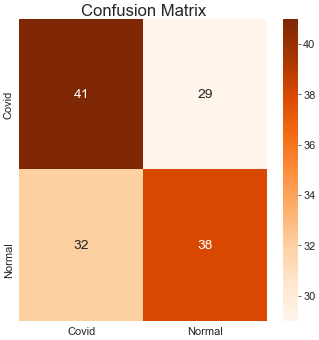

In [37]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sn
warnings.filterwarnings("ignore")
fig = plt.figure(num = None, figsize=(10, 10), dpi=40, facecolor ='w', edgecolor='k')
cm = confusion_matrix(val_generator.classes, y_pred)
conf_matrix = pd.DataFrame(data = cm, 
                           columns = ['Covid', 'Normal'], 
                           index = ['Covid', 'Normal'])
sn.set(font_scale = 1.8)# for label size
sn.heatmap(conf_matrix, annot = True,fmt='.0f', annot_kws = {"size":25}, cmap="Oranges")#font size
plt.title('Confusion Matrix', fontsize =30)
plt.show()

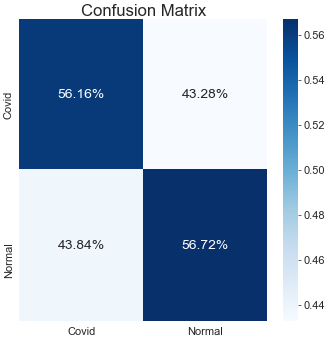

In [38]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sn
warnings.filterwarnings("ignore")
fig = plt.figure(num = None, figsize=(10, 10), dpi=40, facecolor ='w', edgecolor='k')
cm = confusion_matrix(val_generator.classes, y_pred)
conf_matrix = pd.DataFrame(data = cm, 
                            columns = ['Covid', 'Normal'], 
                           index = ['Covid', 'Normal'])
sn.set(font_scale = 1.8)# for label size
sn.heatmap(conf_matrix/np.sum(conf_matrix), annot = True,fmt='.2%', annot_kws = {"size":25}, cmap="Blues")#font size
plt.title('Confusion Matrix', fontsize =30)
plt.show()
#conf_matrix

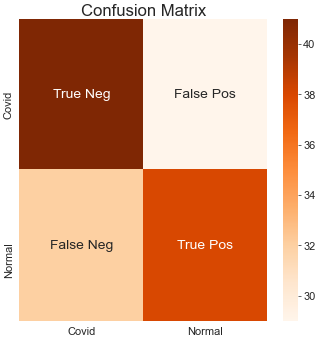

In [39]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sn
warnings.filterwarnings("ignore")
fig = plt.figure(num = None, figsize=(10, 10), dpi=40, facecolor ='w', edgecolor='k')
cm = confusion_matrix(val_generator.classes, y_pred)

conf_matrix = pd.DataFrame(data = cm, 
                            columns = ['Covid', 'Normal'], 
                           index = ['Covid', 'Normal'])

labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)

sn.set(font_scale = 1.8)# for label size
sn.heatmap(conf_matrix, annot =labels, fmt='', annot_kws = {"size":25}, cmap="Oranges")#font size
plt.title('Confusion Matrix', fontsize =30)
plt.show()

<Figure size 400x400 with 0 Axes>

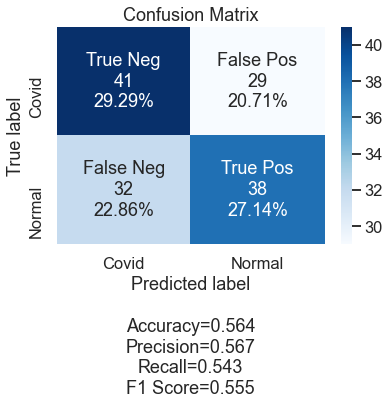

In [40]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sn

from cf_matrix import make_confusion_matrix
sn.set_context('talk')

warnings.filterwarnings("ignore")
fig = plt.figure(num = None, figsize=(10, 10), dpi=40, facecolor ='w', edgecolor='k')
cm = confusion_matrix(val_generator.classes, y_pred)

conf_matrix = np.array(conf_matrix)


labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Covid', 'Normal']

make_confusion_matrix(conf_matrix, group_names=labels, categories=categories, cmap='Blues', title='Confusion Matrix')



In [41]:
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

#r = np.flip(sklearn.metrics.confusion_matrix(y_true, y_pred))
r = (confusion_matrix(val_generator.classes, y_pred))
print("Confusion Matrix")
print(r)

#precision = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
precision = precision_score(y_true=val_generator.classes, y_pred=y_pred)
print('precision')
print(precision)

#recall = sklearn.metrics.recall_score(y_true=test_Y, y_pred=y_pred, pos_label="positive")
recall = recall_score(y_true=val_generator.classes, y_pred=y_pred)
print('recall')                      
print(recall)


#recall = sklearn.metrics.recall_score(y_true=test_Y, y_pred=y_pred, pos_label="positive")
roc_auc = roc_auc_score(val_generator.classes, y_pred, average=None)
print('ROC AUC')                      
print(roc_auc)

#average_precision = average_precision_score(test_Y, y_pred)
#print('Average Precision')                      
#print(average_precision)



Confusion Matrix
[[41 29]
 [32 38]]
precision
0.5671641791044776
recall
0.5428571428571428
ROC AUC
0.5642857142857142


In [42]:
#cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
cm = confusion_matrix(val_generator.classes, y_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[0, 1] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print('Confusion Matrix')
print(cm)
print("accuracy: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))



Confusion Matrix
[[41 29]
 [32 38]]
accuracy: 0.5643
sensitivity: 0.5857
specificity: 0.5672


In [43]:
from sklearn.metrics import classification_report
target_names = ['Covid', 'Normal']

print(classification_report(val_generator.classes, y_pred, target_names = target_names ))


              precision    recall  f1-score   support

       Covid       0.56      0.59      0.57        70
      Normal       0.57      0.54      0.55        70

    accuracy                           0.56       140
   macro avg       0.56      0.56      0.56       140
weighted avg       0.56      0.56      0.56       140



In [44]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del model

In [45]:
# you will need to install numba using "pip install numba"
from numba import cuda

cuda.select_device(0)
cuda.close()